<a href="https://colab.research.google.com/github/NeoLeMarc/colab/blob/main/parse_consors_mail_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define extraction methods

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install -U pandas
#!pip install jedi
#!pip install -U ipython==7.20
!pip install investpy
%config Completer.use_jedi = False

import matplotlib.pyplot as plt
import tensorflow as tf
import os
import string
import re
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from IPython.display import display
from decimal import Decimal

#DATADIR = '/tf/data/consors'
DATADIR = '/content/drive/MyDrive/ml/data/consors'
re_orderfile = re.compile('[0-9]+.txt')
re_orderid = re.compile("Ihre Order mit der Ordernummer ([0-9]+) wurde")
re_depot = re.compile('Ihr Depot: (\*+[0-9]+)')
re_assetname = re.compile('(?:(?:Wertpapiername)|(?:Name)):\s*(\w.*)\n')
re_wkn = re.compile('WKN:\s*(.*)')
re_market = re.compile('Handelsplatz:\s*(.*)')
re_count = re.compile('ck:\s([0-9].*)')
re_comment = re.compile('Orderzusatz:\s*(.*)')
re_value_currency = re.compile('rungskurs:\s*([0-9].*[0-9])\s+(.+)')
re_date = re.compile('Date: (.*)')
re_type = re.compile('Orderart:\s*(\w*)')
os.listdir(DATADIR)
seenmails = []

def parsefile(filename):
    mail = {}
    with open(os.path.join(DATADIR, filename), 'r') as f:
        content = f.read()
        try:
            mail['orderid'] = int(re_orderid.findall(content)[0])
            mail['depot'] = re_depot.findall(content)[0]
            mail['assetname'] = re_assetname.findall(content)[0]
            mail['wkn'] = re_wkn.findall(content)[0]
            mail['market'] = re_market.findall(content)[0]
            mail['count'] = round(float(re_count.findall(content)[0].replace('.','').replace(',', '.')),2)
            mail['comment'] = re_comment.findall(content)[0]
            value, currency = re_value_currency.findall(content)[0]
            mail['value'] = round(float(value.replace('.','').replace(',','.')), 2)
            mail['currency'] = currency
            mail['date'] = re_date.findall(content)[0]
            mail['type'] = re_type.findall(content)[0]
            mail['totalvalue'] = round(float(mail['value']) * float(mail['count']), 2)
            mail['year'] = int(mail['date'].split(' ')[3])
        except Exception as e:
            print("ERROR WHILE PARSING:")
            print(content)
            raise e
    return mail

     |████████████████████████████████| 4.4MB 8.8MB/s 
     |████████████████████████████████| 245kB 41.6MB/s 
     |████████████████████████████████| 6.3MB 37.1MB/s 
     |████████████████████████████████| 512kB 28.2MB/s 
  Created wheel for investpy: filename=investpy-1.0.7-cp37-none-any.whl size=4495223 sha256=b0ef815ff752916f1208422c4af5d59c21a052a213f8bc5308d1ba01b929a1d7
  Stored in directory: /root/.cache/pip/wheels/09/7e/f9/df627561fc57278456e61aa9c63a03dd08e436eb7deab834f0
Successfully built investpy
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """


# Iterate directory and parse mails

In [3]:
def generate_dfm():
    seenmails = []
    mails = []
    for filename in os.listdir(DATADIR):
        if re_orderfile.match(filename):
            mail = parsefile(filename)
            if mail['orderid'] not in seenmails:
                mails.append(mail)
                seenmails.append(mail['orderid'])

    df = pd.DataFrame(mails)
#     display(df)
    dfm = df.query('depot == "******117" and wkn != "510840"')
    return dfm
    
dfm = generate_dfm()

buysum = dfm.query('type == "Kauf"')['totalvalue'].sum()
sellsum = dfm.query('type == "Verkauf"')['totalvalue'].sum()

df1 = pd.DataFrame({'buysum' : [-buysum], 'sellsum' : [sellsum]})
df1.transpose().sum()

dfm.query('type == "Kauf"')['totalvalue'].count()


66

In [4]:
sellassets = dfm.query('type == "Verkauf"')['wkn'].drop_duplicates(keep=False)
buyassets = dfm.query('type == "Kauf"')['wkn'].drop_duplicates(keep=False)
pd.concat([sellassets,buyassets]).drop_duplicates(keep=False)

32     A12UKL
33     747206
112    LYX0AG
14     DZB6HL
15     BP64GN
16     AA7GAZ
24     DG00V3
85     906866
118    A2DVEZ
119    A2H577
120    A2PLDF
Name: wkn, dtype: object

In [5]:
pd.set_option('display.max_rows', 500)

df2 = dfm.groupby(['wkn','assetname','type'])
df2.sum('count')


orderid   count  ...  totalvalue   year
wkn    assetname                 type                        ...                   
519000 BAY.MOTOREN WERKE AG ST   Kauf     146366167    1.31  ...       96.96   4026
                                 Verkauf  198814371    1.31  ...       93.99   4032
541910 CANCOM SE O.N.            Kauf      99771458   40.00  ...     2060.00   2016
                                 Verkauf   99788400   40.00  ...     2010.00   2016
553340 DT.GRUNDST.AUKT.AG        Kauf      74668265    3.00  ...       39.63   2013
                                 Verkauf   80989387    3.00  ...       33.00   2014
578560 FRESENIUS SE+CO.KGAA O.N. Kauf      73226024    0.24  ...       22.84   2013
                                 Verkauf  113935548    0.71  ...       51.94   2017
578580 FRESEN.MED.CARE KGAA O.N. Kauf      87021647   27.00  ...     1999.08   2015
                                 Verkauf   88133518   27.00  ...     1984.50   2015
632313 OMNICELL INC.     DL-,001 Kauf      74668401    2.00  ...       47.42   2013
                                 Verkauf   80989398    2.00  ...       59.14   2014
747206 WIRECARD AG               Kauf     162185872   81.00  ...     2485.80   4028
                                 Verkauf   86403684   81.00  ...     3186.54   2015
850663 COCA-COLA CO.      DL-,25 Kauf      88926116   55.00  ...     2007.50   2015
                                 Verkauf  113935545   55.00  ...     2145.00   2017
863186 ADVANCED MIC.DEV.  DL-,01 Kauf     108027861  184.00  ...     2496.88   2017
                                 Verkauf  108035029  184.00  ...     2156.48   2017
878841 CISCO SYSTEMS    DL-,001  Kauf      99466582   82.00  ...     2091.00   2016
                                 Verkauf   99525694   82.00  ...     2038.52   2016
886455 ASTRAZENECA PLC    DL-,25 Kauf      89835077   41.00  ...     2398.50   2015
                                 Verkauf   99407184   41.00  ...     2071.73   2016
906866 AMAZON.COM INC.    DL-,01 Kauf     118522400    6.00  ...     5724.00   2017
                                 Verkauf  301022534    6.00  ...    10418.60   4039
916541 NTT DOCOMO INC.           Kauf      99788521   91.00  ...     2089.36   2016
                                 Verkauf   99788561   91.00  ...     2006.55   2016
941034 F.TEM.INV-T.GWTH A ACC    Kauf     149328001    7.23  ...       97.38   4026
                                 Verkauf  354424718   21.66  ...      376.23   6051
A0HGWC IS MSCI EM U.ETF USD D    Kauf     143576374  214.00  ...     7327.36   2019
                                 Verkauf  157137891  214.00  ...     8018.58   2020
A0J36V ERSTE RESPON.STOCK GL A   Kauf     507646741   12.35  ...     2304.36  12086
                                 Verkauf  198814375   12.35  ...     2098.51   4032
A0Q4DC NESTLE NAM.        SF-,10 Kauf      91219077   29.00  ...     2016.08   2015
                                 Verkauf   99407189   29.00  ...     1902.11   2016
A0RPWH ISHSIII-CORE MSCI WLD DLA Kauf     232576645  280.00  ...    12278.00   4034
                                 Verkauf  238653399  280.00  ...    12605.60   4034
A0YJQ2 BERKSH. H.B NEW DL-,00333 Kauf      87020658   20.00  ...     2605.20   2015
                                 Verkauf   88133479   20.00  ...     2450.00   2015
A12UKL TELEFONICA DTLD HLDG BZR  Verkauf   82638319   20.00  ...       16.40   2014
A14Y6F ALPHABET INC.CL.A DL-,001 Kauf     431884193   20.00  ...    16016.54   8066
                                 Verkauf  489429241   20.00  ...    19363.39   8070
A1CX3T TESLA MOTORS INC. DL-,001 Kauf      99466614   11.00  ...     2154.35   2016
                                 Verkauf   99525773   11.00  ...     2116.84   2016
A1J5RX TELEFONICA DTLD HLDG AG   Kauf      74668145   20.00  ...      118.80   2013
                                 Verkauf   87021069   20.00  ...       98.20   2015
A1JX53 VANGUARD S+P 500 U.ETF DL Kauf     120130263  150.00  ...     6469.50   2017
       VANGU

In [6]:
# df.query('wkn == "747206"')
# df['depot'].unique()

In [7]:
invested_capital = -df1.transpose().sum()
current_value = 43558.20

total_win = current_value - invested_capital

total_win

0    13641.43
dtype: float64

In [8]:
gain = (total_win * 100.0)/invested_capital
gain

0    45.597937
dtype: float64

In [9]:
anual_gain = gain/(2021-2013)
anual_gain

0    5.699742
dtype: float64

In [10]:
display(dfm['year'])

0      2013
1      2013
2      2013
3      2013
4      2013
5      2013
6      2013
7      2013
9      2013
10     2013
11     2013
12     2013
13     2013
14     2013
15     2013
16     2013
17     2013
18     2014
19     2015
20     2014
21     2014
22     2014
23     2014
24     2014
25     2014
26     2014
27     2014
28     2014
29     2014
30     2014
31     2014
32     2014
33     2015
34     2015
35     2015
36     2015
37     2015
38     2015
39     2015
40     2015
41     2015
42     2015
43     2015
44     2015
45     2015
46     2015
47     2015
48     2015
49     2015
50     2015
51     2015
52     2015
53     2016
54     2015
55     2015
56     2015
57     2016
58     2016
59     2016
60     2016
61     2016
62     2016
63     2016
64     2016
65     2016
66     2016
67     2016
68     2016
69     2016
70     2016
71     2016
72     2016
73     2016
74     2017
75     2017
76     2017
77     2017
78     2017
79     2017
80     2017
81     2017
82     2017
83     2017
84  

# Depotbestand pro Jahr

In [11]:
def calculate_depot_years(dfm):
    years = dfm['year'].unique()
    dfm_years = {}
    wkn_lookup = dfm[['wkn', 'assetname']].groupby(['wkn']).max('assetname')
    dfm['price'] = dfm['value'].apply(lambda x : float(x))
    
    for year in years:
        print(".",end='.')
        price_year = dfm.query("year <= %i and type == 'Kauf' and value >= 0" % year)[['wkn','price']].rename(columns={'value' : 'price'}).groupby(['wkn']).mean()
        buy_year = dfm.query("year <= %i and type == 'Kauf'" % year)[['year','wkn','assetname','count']].groupby(['wkn','assetname', 'year']).sum()
        sell_year = dfm.query("year <= %i and type == 'Verkauf'" % year)[['year','wkn','assetname','count']].groupby(['wkn','assetname', 'year']).sum()
        if 'count' in sell_year and len(sell_year) > 0:
            sell_year = sell_year['count'].mul(-1)
        else:
            # Get right column names for year without sales - otherwise merge will not work
            sell_year = buy_year.copy().query("wkn == 'foo'")
        alls = pd.merge(buy_year, sell_year, how='outer', on=['wkn', 'assetname','year'])
        total = alls.groupby(['wkn']).sum()
        total['total'] = total['count_x'] + total['count_y']
        total = pd.merge(total, price_year, how='left', on='wkn')
        total = pd.merge(total, wkn_lookup, how='left', on='wkn')
        dfm_years[year] = {'buys' : buy_year, 'sells' : sell_year, 'combined' : alls, 'totals' :total}
    return dfm_years

dfm_years = calculate_depot_years(dfm)

# for year in dfm_years:
#     dfm_year = dfm_years[year]
#     print("Bestand in %s" % year)
#     display(dfm_year['totals'].query('abs(total) > 0.1'))
#     print("\n\n\n")
    
    
wkn_options = ['DZB6HL','DG00V3','BP64GN','AA7GAZ']

................

## Probleme im Datensatz
### Optionen sind immer noch im Depot vorhanden
Für verfallende Optionen verschickt Consors keine Transaktionsbestätigung. Diese sind diese in unserem virtuellen Depot noch vorhanden. Um dieses Problem zu beheben, erstellen wir virtueller Gegenbuchungen, 
die im Kaufjahr der Option von einem Totalverlust ausgehen

In [12]:
dfmo = dfm.copy()

for wkn in wkn_options:
    transactions = dfmo.query('wkn == "%s"' % wkn).copy()
    transactions['value'] = 0
    transactions['type'] = 'Verkauf'
    transactions['totalvalue'] = 0.01
    transactions['comment'] = 'Option verfallen'
    dfmo = dfmo.append(transactions)
    
for wkn in wkn_options:
    transactions = dfmo.query('wkn == "%s"' % wkn)
    display(transactions)

,orderid,depot,assetname,wkn,market,count,comment,value,currency,date,type,totalvalue,year,price
14,73161459,******117,DZ BANK CALL13 VOW,DZB6HL,au=DFerb=F6rslicher Handel,20.0,Limit Order,2.77,EUR,"Wed, 31 Jul 2013 08:05:57 +0200",Kauf,55.40,2013,2.77
14,73161459,******117,DZ BANK CALL13 VOW,DZB6HL,au=DFerb=F6rslicher Handel,20.0,Option verfallen,0.00,EUR,"Wed, 31 Jul 2013 08:05:57 +0200",Verkauf,0.01,2013,2.77


,orderid,depot,assetname,wkn,market,count,comment,value,currency,date,type,totalvalue,year,price
24,81125550,******117,DZ BANK PUT15 WDI,DG00V3,au=DFerb=F6rslicher Handel,750.0,Limit Order,0.47,EUR,"Mon, 14 Jul 2014 10:29:38 +0200",Kauf,352.50,2014,0.47
24,81125550,******117,DZ BANK PUT15 WDI,DG00V3,au=DFerb=F6rslicher Handel,750.0,Option verfallen,0.00,EUR,"Mon, 14 Jul 2014 10:29:38 +0200",Verkauf,0.01,2014,0.47


,orderid,depot,assetname,wkn,market,count,comment,value,currency,date,type,totalvalue,year,price
15,73161394,******117,BNP PAR.EHG DISCP13 ALV,BP64GN,au=DFerb=F6rslicher Handel,10.0,Limit Order,2.34,EUR,"Tue, 30 Jul 2013 09:00:44 +0200",Kauf,23.40,2013,2.34
15,73161394,******117,BNP PAR.EHG DISCP13 ALV,BP64GN,au=DFerb=F6rslicher Handel,10.0,Option verfallen,0.00,EUR,"Tue, 30 Jul 2013 09:00:44 +0200",Verkauf,0.01,2013,2.34


,orderid,depot,assetname,wkn,market,count,comment,value,currency,date,type,totalvalue,year,price
16,73161489,******117,RBS PLC DISC.Z13 XPD,AA7GAZ,au=DFerb=F6rslicher Handel,1.0,Limit Order,71.77,EUR,"Tue, 30 Jul 2013 09:00:05 +0200",Kauf,71.77,2013,71.77
16,73161489,******117,RBS PLC DISC.Z13 XPD,AA7GAZ,au=DFerb=F6rslicher Handel,1.0,Option verfallen,0.00,EUR,"Tue, 30 Jul 2013 09:00:05 +0200",Verkauf,0.01,2013,71.77


## Negative Bestände im Portfolio

Es gibt Positionen im Portfolio, zu denen nur ein Verkauf ohne einen zugehörigen Kauf vermerkt ist. Diese analysieren wir genauer.

In [13]:
negative_positions = dfm_years[max(dfm_years.keys())]['totals'].query('total < 0')
display(negative_positions)

np_with_orders = pd.merge(negative_positions, dfmo, how='left', on='wkn').sort_values(['wkn', 'orderid'])
display(np_with_orders)

,count_x,count_y,total,price,assetname
wkn,,,,,
578560,0.24,-0.71,-0.47,95.180,FRESENIUS SE+CO.KGAA O.N.
941034,7.23,-21.66,-14.43,13.260,F.TEM.INV-T.GWTH A ACC
A12UKL,0.00,-20.00,-20.00,NaN,TELEFONICA DTLD HLDG BZR
ETF003,2.97,-2.98,-0.01,25.035,COMST.-DIVDAX TR U.ETF I


,wkn,count_x,count_y,total,price_x,assetname_x,orderid,depot,assetname_y,market,count,comment,value,currency,date,type,totalvalue,year,price_y
0,578560,0.24,-0.71,-0.47,95.180,FRESENIUS SE+CO.KGAA O.N.,73226024,******117,FRESENIUS SE+CO.KGAA O.N.,Sparplan,0.24,Market Order,95.18,EUR,"Thu, 1 Aug 2013 08:44:56 +0200",Kauf,22.84,2013,95.18
1,578560,0.24,-0.71,-0.47,95.180,FRESENIUS SE+CO.KGAA O.N.,113935548,******117,FRESENIUS SE+CO.KGAA O.N.,Sparplan,0.71,Market Order,73.16,EUR,"Mon, 24 Jul 2017 16:16:09 +0200 (CEST)",Verkauf,51.94,2017,73.16
3,941034,7.23,-21.66,-14.43,13.260,F.TEM.INV-T.GWTH A ACC,73295462,******117,F.TEM.INV-T.GWTH A ACC,Fondsgesellschaft,1.90,Market Order,12.82,EUR,"Fri, 2 Aug 2013 13:09:36 +0200",Kauf,24.36,2013,12.82
2,941034,7.23,-21.66,-14.43,13.260,F.TEM.INV-T.GWTH A ACC,76032539,******117,F.TEM.INV-T.GWTH A ACC,Fondsgesellschaft,5.33,Market Order,13.70,EUR,"Tue, 3 Dec 2013 13:03:34 +0100",Kauf,73.02,2013,13.70
6,941034,7.23,-21.66,-14.43,13.260,F.TEM.INV-T.GWTH A ACC,113935547,******117,F.TEM.INV-T.GWTH A ACC,Fondsgesellschaft,7.22,Market Order,17.37,EUR,"Tue, 25 Jul 2017 11:03:56 +0200 (CEST)",Verkauf,125.41,2017,17.37
4,941034,7.23,-21.66,-14.43,13.260,F.TEM.INV-T.GWTH A ACC,120244585,******117,F.TEM.INV-T.GWTH A ACC,Fondsgesellschaft,7.22,Market Order,17.37,EUR,"Mon, 18 Dec 2017 17:31:43 +0100 (CET)",Verkauf,125.41,2017,17.37
5,941034,7.23,-21.66,-14.43,13.260,F.TEM.INV-T.GWTH A ACC,120244586,******117,F.TEM.INV-T.GWTH A ACC,Fondsgesellschaft,7.22,Market Order,17.37,EUR,"Mon, 18 Dec 2017 17:31:43 +0100 (CET)",Verkauf,125.41,2017,17.37
7,A12UKL,0.00,-20.00,-20.00,NaN,TELEFONICA DTLD HLDG BZR,82638319,******117,TELEFONICA DTLD HLDG BZR,Frankfurt,20.00,Market Order,0.82,EUR,"Fri, 19 Sep 2014 13:27:53 +0200",Verkauf,16.40,2014,0.82
8,ETF003,2.97,-2.98,-0.01,25.035,COMST.-DIVDAX TR U.ETF I,81150709,******117,COMST.-DIVDAX TR U.ETF I,M=FCnchen,1.95,Market Order,25.59,EUR,"Tue, 15 Jul 2014 08:52:50 +0200",Kauf,49.90,2014,25.59
9,ETF003,2.97,-2.98,-0.01,25.035,COMST.-DIVDAX TR U.ETF I,81524824,******117,COMST.-DIVDAX TR U.ETF I,M=FCnchen,1.02,Market Order,24.48,EUR,"Fri, 1 Aug 2014 09:23:20 +0200",Kauf,24.97,2014,24.48


Der Effekt ist tatsächlich ein Arteufakt im Umgang von Cortal-Consors mit Sparpläne. Bei Sparplänen werden für die automatischen Käufe keine Transaktionsmails verschickt, sehr wohl jedoch für "manuelle" Nachkäufe. Dies führt dazu, dass die Summen nicht mehr stimmen. Um dies zu korrigieren, führen wir virtuelle Gegenbuchungen über die Fehlbeträge zum Zeitpunkt der Verkäufe ein.

In [14]:
print(list(dfmo.columns))

['orderid', 'depot', 'assetname', 'wkn', 'market', 'count', 'comment', 'value', 'currency', 'date', 'type', 'totalvalue', 'year', 'price']


In [15]:
counterbookings = np_with_orders.query('type == "Verkauf"').groupby('wkn').min().copy()
counterbookings['orderid'] = counterbookings['orderid'] + 1
counterbookings['count'] = -counterbookings['total']
counterbookings['totalvalue'] = counterbookings['count'] * counterbookings['value']
counterbookings['comment'] = 'Korrekturbuchung'
counterbookings['type'] = 'Kauf'
counterbookings = counterbookings.rename(columns ={'assetname_x' : 'assetname', 'wkn_x' : 'wkn'}).drop(columns = ['count_x', 'count_y', 'assetname_y','total']).reset_index()

dfmok = pd.concat([dfmo, counterbookings], axis=0).copy()
display(dfmok.sort_values('orderid'))

,orderid,depot,assetname,wkn,market,count,comment,value,currency,date,type,totalvalue,year,price,price_x,price_y
17,73140355,******117,BAY.MOTOREN WERKE AG ST,519000,Cortal Consors Preis / TRG,1.00,Limit Order,74.21,EUR,"Mon, 29 Jul 2013 08:00:21 +0200",Kauf,74.2100,2013,74.21,NaN,NaN
15,73161394,******117,BNP PAR.EHG DISCP13 ALV,BP64GN,au=DFerb=F6rslicher Handel,10.00,Option verfallen,0.00,EUR,"Tue, 30 Jul 2013 09:00:44 +0200",Verkauf,0.0100,2013,2.34,NaN,NaN
15,73161394,******117,BNP PAR.EHG DISCP13 ALV,BP64GN,au=DFerb=F6rslicher Handel,10.00,Limit Order,2.34,EUR,"Tue, 30 Jul 2013 09:00:44 +0200",Kauf,23.4000,2013,2.34,NaN,NaN
14,73161459,******117,DZ BANK CALL13 VOW,DZB6HL,au=DFerb=F6rslicher Handel,20.00,Limit Order,2.77,EUR,"Wed, 31 Jul 2013 08:05:57 +0200",Kauf,55.4000,2013,2.77,NaN,NaN
14,73161459,******117,DZ BANK CALL13 VOW,DZB6HL,au=DFerb=F6rslicher Handel,20.00,Option verfallen,0.00,EUR,"Wed, 31 Jul 2013 08:05:57 +0200",Verkauf,0.0100,2013,2.77,NaN,NaN
16,73161489,******117,RBS PLC DISC.Z13 XPD,AA7GAZ,au=DFerb=F6rslicher Handel,1.00,Option verfallen,0.00,EUR,"Tue, 30 Jul 2013 09:00:05 +0200",Verkauf,0.0100,2013,71.77,NaN,NaN
16,73161489,******117,RBS PLC DISC.Z13 XPD,AA7GAZ,au=DFerb=F6rslicher Handel,1.00,Limit Order,71.77,EUR,"Tue, 30 Jul 2013 09:00:05 +0200",Kauf,71.7700,2013,71.77,NaN,NaN
13,73225812,******117,BAY.MOTOREN WERKE AG ST,519000,Sparplan,0.31,Market Order,73.39,EUR,"Thu, 1 Aug 2013 08:42:23 +0200",Kauf,22.7500,2013,73.39,NaN,NaN
12,73226024,******117,FRESENIUS SE+CO.KGAA O.N.,578560,Sparplan,0.24,Market Order,95.18,EUR,"Thu, 1 Aug 2013 08:44:56 +0200",Kauf,22.8400,2013,95.18,NaN,NaN
11,73248028,******117,BNP PAR.EHG O.E.IDX.Z DAX,BN3DAX,Sparplan,0.27,Market Order,83.22,EUR,"Thu, 1 Aug 2013 13:03:57 +0200",Kauf,22.4700,2013,83.22,NaN,NaN


### Überprüfung des Resultats

In [16]:
dfm_years = calculate_depot_years(dfmok)
assets_in_posession = dfm_years[max(dfm_years.keys())]['totals'].query("total > 0")

for year in dfm_years:
    dfm_year = dfm_years[year]
    print("Bestand in %s" % year)
    display(dfm_year['totals'].query("total != 0"))
    print("\n\n\n")
    
print("Aktueller Bestand")
display(assets_in_posession)

................Bestand in 2013


,count_x,count_y,total,price,assetname
wkn,,,,,
519000,1.31,0.0,1.31,73.800,BAY.MOTOREN WERKE AG ST
553340,3.00,0.0,3.00,13.210,DT.GRUNDST.AUKT.AG
578560,0.24,0.0,0.24,95.180,FRESENIUS SE+CO.KGAA O.N.
632313,2.00,0.0,2.00,23.710,"OMNICELL INC. DL-,001"
941034,7.23,0.0,7.23,13.260,F.TEM.INV-T.GWTH A ACC
A0J36V,0.32,0.0,0.32,156.495,ERSTE RESPON.STOCK GL A
A1J5RX,20.00,0.0,20.00,5.940,TELEFONICA DTLD HLDG AG
BN3DAX,1.27,0.0,1.27,84.765,BNP PAR.EHG O.E.IDX.Z DAX
DBX1DA,1.08,0.0,1.08,92.960,DB X-TRACKERS DAX ETF 1C






Bestand in 2014


,count_x,count_y,total,price,assetname
wkn,,,,,
519000,1.31,0.0,1.31,73.800000,BAY.MOTOREN WERKE AG ST
578560,0.24,0.0,0.24,95.180000,FRESENIUS SE+CO.KGAA O.N.
747206,81.00,0.0,81.00,31.040000,WIRECARD AG
941034,7.23,0.0,7.23,13.260000,F.TEM.INV-T.GWTH A ACC
A0J36V,0.33,0.0,0.33,156.303333,ERSTE RESPON.STOCK GL A
A1J5RX,20.00,0.0,20.00,5.940000,TELEFONICA DTLD HLDG AG
BN3DAX,1.27,0.0,1.27,84.765000,BNP PAR.EHG O.E.IDX.Z DAX
DBX1D3,4.19,0.0,4.19,18.140000,DB X-TR.EU.ST.S.D.30DR 1D
DBX1DA,9.24,0.0,9.24,91.710000,DB X-TRACKERS DAX ETF 1C






Bestand in 2015


,count_x,count_y,total,price,assetname
wkn,,,,,
519000,1.31,0.0,1.31,73.800,BAY.MOTOREN WERKE AG ST
578560,0.24,0.0,0.24,95.180,FRESENIUS SE+CO.KGAA O.N.
850663,55.00,0.0,55.00,36.500,"COCA-COLA CO. DL-,25"
886455,41.00,0.0,41.00,58.500,"ASTRAZENECA PLC DL-,25"
941034,7.23,0.0,7.23,13.260,F.TEM.INV-T.GWTH A ACC
A0J36V,12.34,0.0,12.34,170.404,ERSTE RESPON.STOCK GL A
A0Q4DC,29.00,0.0,29.00,69.520,"NESTLE NAM. SF-,10"






Bestand in 2016


,count_x,count_y,total,price,assetname
wkn,,,,,
578560,0.24,0.0,0.24,95.18,FRESENIUS SE+CO.KGAA O.N.
850663,55.00,0.0,55.00,36.50,"COCA-COLA CO. DL-,25"
941034,7.23,0.0,7.23,13.26,F.TEM.INV-T.GWTH A ACC
A14Y6F,6.00,-3.0,3.00,655.85,"ALPHABET INC.CL.A DL-,001"






Bestand in 2017


,count_x,count_y,total,price,assetname
wkn,,,,,
906866,6.0,0.0,6.0,954.000,"AMAZON.COM INC. DL-,01"
A14Y6F,20.0,-13.0,7.0,759.405,"ALPHABET INC.CL.A DL-,001"
A1JX53,150.0,0.0,150.0,43.130,VANGUARD S+P 500U.ETF DLD
LYX0AG,36.0,0.0,36.0,174.270,LYX.MSCI WORLD U.ETF DEO
LYX0R1,45.0,0.0,45.0,146.110,L.GE.MI.-CA.MDAX UETFDEO






Bestand in 2019


,count_x,count_y,total,price,assetname
wkn,,,,,
906866,6.00,-1.0,5.00,954.000000,"AMAZON.COM INC. DL-,01"
A0HGWC,214.00,0.0,214.00,34.240000,IS MSCI EM U.ETF USD D
A14Y6F,20.00,-13.0,7.00,759.405000,"ALPHABET INC.CL.A DL-,001"
A1JX53,150.00,0.0,150.00,43.130000,VANGUARD S+P 500U.ETF DLD
DWS0R4,7.41,0.0,7.41,202.276667,ARERO-DER WELTFONDS INH.
LYX0AG,39.00,0.0,39.00,181.195000,LYX.MSCI WORLD U.ETF DEO






Bestand in 2020


,count_x,count_y,total,price,assetname
wkn,,,,,
DWS0R4,7.41,0.0,7.41,202.276667,ARERO-DER WELTFONDS INH.






Bestand in 2021


,count_x,count_y,total,price,assetname
wkn,,,,,
A2DVEZ,900.00,0.0,900.00,15.3700,BNPPE-M.W.SRI SS5C. UECEO
A2H577,105.00,0.0,105.00,121.8400,AIS-AM.MSCI NDQ100 EOC
A2PLDF,72.00,0.0,72.00,35.0800,VANECK ETFS-VVVG+ESP.ADLA
DWS0R4,57.41,0.0,57.41,211.2375,ARERO-DER WELTFONDS INH.






Aktueller Bestand


,count_x,count_y,total,price,assetname
wkn,,,,,
A2DVEZ,900.00,0.0,900.00,15.3700,BNPPE-M.W.SRI SS5C. UECEO
A2H577,105.00,0.0,105.00,121.8400,AIS-AM.MSCI NDQ100 EOC
A2PLDF,72.00,0.0,72.00,35.0800,VANECK ETFS-VVVG+ESP.ADLA
DWS0R4,57.41,0.0,57.41,211.2375,ARERO-DER WELTFONDS INH.


# Aufsummieren von Ausgaben und Einnahmen

In [17]:
sum_buys = 0
sum_sells = 0
sum_wkn = {}
sum_sequence = pd.DataFrame({'orderid' : [], 'buys' : [], 'sells' : [], 'total' : [], 'date' : []})

#display(dfmok.sort_values('orderid'))
type(dfmok)

for i, row in dfmok.sort_values('orderid').iterrows():
    wkn = row['wkn']
    
    if wkn not in sum_wkn.keys():
        sum_wkn[wkn] = {'wkn' : wkn, 'buys' : 0, 'sells' : 0, 'total' : 0}
        
    if row['type'] == 'Verkauf':
        sum_sells += row['totalvalue']
        sum_wkn[wkn]['sells'] += row['totalvalue']
    else:
        sum_buys += row['totalvalue']
        sum_wkn[wkn]['buys'] += row['totalvalue']

    total = sum_sells - sum_buys
    
    sum_wkn[wkn]['total'] = sum_wkn[wkn]['sells'] - sum_wkn[wkn]['buys']
    sum_sequence = sum_sequence.append({'oderid' : row['orderid'], 'buys' : sum_buys, 'sells' : sum_sells, 'total' : total, 'date' : row['date']}, ignore_index=True)
    
sum_sequence.sort_values('orderid')
sum_sequence.columns = ['old', 'buys', 'sells', 'total', 'date', 'orderid']
sum_sequence = sum_sequence.drop(columns = 'old')
display(sum_sequence)


,buys,sells,total,date,orderid
0,74.2100,0.00,-74.2100,"Mon, 29 Jul 2013 08:00:21 +0200",73140355.0
1,74.2100,0.01,-74.2000,"Tue, 30 Jul 2013 09:00:44 +0200",73161394.0
2,97.6100,0.01,-97.6000,"Tue, 30 Jul 2013 09:00:44 +0200",73161394.0
3,153.0100,0.01,-153.0000,"Wed, 31 Jul 2013 08:05:57 +0200",73161459.0
4,153.0100,0.02,-152.9900,"Wed, 31 Jul 2013 08:05:57 +0200",73161459.0
5,153.0100,0.03,-152.9800,"Tue, 30 Jul 2013 09:00:05 +0200",73161489.0
6,224.7800,0.03,-224.7500,"Tue, 30 Jul 2013 09:00:05 +0200",73161489.0
7,247.5300,0.03,-247.5000,"Thu, 1 Aug 2013 08:42:23 +0200",73225812.0
8,270.3700,0.03,-270.3400,"Thu, 1 Aug 2013 08:44:56 +0200",73226024.0
9,292.8400,0.03,-292.8100,"Thu, 1 Aug 2013 13:03:57 +0200",73248028.0


# Erträge und Verluste pro WKN
## TODO: Wert der Assets aus der Historie abholen

In [18]:
dfsw = pd.DataFrame(sum_wkn).transpose()
wkn_lookup = dfm[['wkn', 'assetname']].groupby(['wkn']).max('assetname')

dfsw = pd.merge(wkn_lookup, dfsw, how='right', on=['wkn'])
dfsw = dfsw.sort_values('total', axis=0, ascending=False)

dfsw['total'] = dfsw['total'].apply(lambda x: round(x, 2))
dfsw['buys'] = dfsw['buys'].apply(lambda x: round(x, 2))
dfsw['sells'] = dfsw['sells'].apply(lambda x: round(x, 2))

print("Aktueller Bestand")
display(assets_in_posession)

print("\n\n\nGewinne")
wins = dfsw.query('total > 0')
display(wins)
print("Summe: %.2f" % round(wins.sum()['total'], 2))

print("\n\n\nVerluste")
losses = dfsw.sort_values('total', axis=0, ascending=True).query('total <= 0 and sells > 0')
display(losses)
print("Summe: %.2f" % round(losses.sum()['total'], 2))

print("\n\n\nOffene Positionen")
opens = dfsw.sort_values('total', axis=0, ascending=True).query('total <= 0 and sells == 0')
display(opens)
print("Summe: %.2f" % round(opens.sum()['total'], 2))

invested_capital = abs(dfsw.sum()['total'])
print("\n\n\nInvestiertes Kapital: %6.2f Euro" % invested_capital)

Aktueller Bestand


,count_x,count_y,total,price,assetname
wkn,,,,,
A2DVEZ,900.00,0.0,900.00,15.3700,BNPPE-M.W.SRI SS5C. UECEO
A2H577,105.00,0.0,105.00,121.8400,AIS-AM.MSCI NDQ100 EOC
A2PLDF,72.00,0.0,72.00,35.0800,VANECK ETFS-VVVG+ESP.ADLA
DWS0R4,57.41,0.0,57.41,211.2375,ARERO-DER WELTFONDS INH.





Gewinne


,wkn,assetname,buys,sells,total
33,906866,"AMAZON.COM INC. DL-,01",5724.00,10418.60,4694.60
23,A14Y6F,"ALPHABET INC.CL.A DL-,001",16016.54,19363.39,3346.85
35,A1JX53,VANGUARD S+P 500U.ETF DLD,6469.50,8554.50,2085.00
36,LYX0AG,LYX.MSCI WORLD U.ETF DEO,6838.08,8317.14,1479.06
13,747206,WIRECARD AG,2485.80,3186.54,700.74
37,A0HGWC,IS MSCI EM U.ETF USD D,7327.36,8018.58,691.22
31,A1W4DP,BNPPE S+P 500 U.ETF CEO,12301.30,12751.27,449.97
32,A0RPWH,ISHSIII-CORE MSCI WLD DLA,12278.00,12605.60,327.60
30,ETFL44,DEKA MDAX,12717.47,13000.03,282.56
12,DBX1DA,DB X-TRACKERS DAX ETF 1C,1057.47,1289.14,231.67


Summe: 14570.80



Verluste


,wkn,assetname,buys,sells,total
14,DG00V3,DZ BANK PUT15 WDI,352.50,0.01,-352.49
28,863186,"ADVANCED MIC.DEV. DL-,01",2496.88,2156.48,-340.40
21,886455,"ASTRAZENECA PLC DL-,25",2398.50,2071.73,-326.77
34,LYX0R1,L.GE.MI.-CA.MDAX UETFDEO,6574.95,6260.40,-314.55
7,A0J36V,ERSTE RESPON.STOCK GL A,2304.36,2098.51,-205.85
18,A0YJQ2,"BERKSH. H.B NEW DL-,00333",2605.20,2450.00,-155.20
22,A0Q4DC,"NESTLE NAM. SF-,10",2016.08,1902.11,-113.97
27,916541,NTT DOCOMO INC.,2089.36,2006.55,-82.81
3,AA7GAZ,RBS PLC DISC.Z13 XPD,71.77,0.01,-71.76
2,DZB6HL,DZ BANK CALL13 VOW,55.40,0.01,-55.39


Summe: -2232.64



Offene Positionen


,wkn,assetname,buys,sells,total
39,A2DVEZ,BNPPE-M.W.SRI SS5C. UECEO,13833.00,0.0,-13833.00
38,DWS0R4,ARERO-DER WELTFONDS INH.,13404.66,0.0,-13404.66
40,A2H577,AIS-AM.MSCI NDQ100 EOC,12793.20,0.0,-12793.20
41,A2PLDF,VANECK ETFS-VVVG+ESP.ADLA,2525.76,0.0,-2525.76


Summe: -42556.62



Investiertes Kapital: 30218.46 Euro


## Aktuelle Investments


In [19]:
import investpy

# Translate wkns to isins
isin_from_wkn = {'A2DVEZ' : 'LU1615092217', 
                 'A2H577' : 'LU1681038243', 
                 'A2PLDF' : 'IE00BYWQWR46', 
                 'DWS0R4' : 'LU0360863863',
                 '941034' : 'LU0114760746',
                 '632313' : 'US68213N1090',
                 'A0J36V' : 'AT0000A0FSN4',
                 'DWS0R4' : 'LU0360863863'
                }

# Assets that had been delisted
ignoreassets    = ['BN3DAX', 'A12UKL', 'BP64GN', 'DZB6HL', 'AA7GAZ', '916541', 'DG00V3']

usd_to_euro = Decimal(str(float(investpy.currency_crosses.get_currency_cross_information('EUR/USD')['Bid'])))

def euro(usd):
    return Decimal(usd_to_euro * usd)

def get_current_values(assetlist):
    current_values_ls = []

    for wkn,group in assetlist.transpose().items():
        print('.', end='')
        result_in = investpy.search_quotes(text=isin_from_wkn[wkn])

        if type(result_in) == type([]):
            for r in result_in:
                result = r
#                 print(r.exchange)
                if r.exchange.lower() in ['xetra', 'frankfurt', 'paris', 'Luxembourg']:
#                     print("!")
                    break
        else:
            result = result_in
        current_value = float(str(result.retrieve_recent_data().sort_values('Date').iloc[-1]['Close']))
        current_values_ls.append({'wkn' : wkn,'eur' : current_value})
    return pd.DataFrame(current_values_ls)

def get_historic_values(assetlist, year):
    historic_values_ls = []

    for wkn,group in assetlist.transpose().items():
        print('.', end='')
        
        if wkn in isin_from_wkn.keys():
            key = isin_from_wkn[wkn]
        elif wkn in ignoreassets:
            continue
        else:
            key = wkn
        try:
            result_in = investpy.search_quotes(text=key)
        except IndexError:
            print("Failed to get data for %s" % key)
            continue
        if type(result_in) == type([]):
            for r in result_in:
                result = r
#                 print(r.exchange)
                if r.exchange.lower() in ['xetra', 'frankfurt', 'paris', 'Luxembourg']:
#                     print("!")
                    break
        else:
            result = result_in
        try:
            dataset = result.retrieve_historical_data(from_date="23/12/%s" %year, to_date="31/12/%s" %year)
            historic_value = float(str(dataset.sort_values('Date').iloc[-1]['Close']))
        except IndexError:
            print(" E: %s " % key, end='.')
            continue
        historic_values_ls.append({'wkn' : wkn,'eur' : historic_value, 'year' : year})
    return pd.DataFrame(historic_values_ls)

## TEST
display(get_historic_values(assets_in_posession, 2013))
## END TEST

current_values = get_current_values(assets_in_posession)
display(current_values)

pos_with_value = pd.merge(assets_in_posession, current_values, how='left', on='wkn')

. E: LU1615092217 ... E: IE00BYWQWR46 .. E: LU0360863863 .

,wkn,eur,year
0,A2H577,27.42,2013


....

,wkn,eur
0,A2DVEZ,15.61
1,A2H577,129.30
2,A2PLDF,36.13
3,DWS0R4,243.81


In [20]:
pos_with_value['total_value'] = pos_with_value['total'] * pos_with_value['eur']
pos_with_value['total_value'] = pos_with_value['total_value'].apply(lambda x: round(x, 2))
display(pos_with_value)

total = pos_with_value['total_value'].sum()
print("Gesamtwert: %s Euro" % total)
print("Investiertes Kapital: %s" % invested_capital)
profit = total-invested_capital
profit_percent = profit * float(100) / invested_capital
print("Wertentwicklung ohne Dividende: %.2f (%.2f%%)" % (profit, profit_percent))

,wkn,count_x,count_y,total,price,assetname,eur,total_value
0,A2DVEZ,900.00,0.0,900.00,15.3700,BNPPE-M.W.SRI SS5C. UECEO,15.61,14049.00
1,A2H577,105.00,0.0,105.00,121.8400,AIS-AM.MSCI NDQ100 EOC,129.30,13576.50
2,A2PLDF,72.00,0.0,72.00,35.0800,VANECK ETFS-VVVG+ESP.ADLA,36.13,2601.36
3,DWS0R4,57.41,0.0,57.41,211.2375,ARERO-DER WELTFONDS INH.,243.81,13997.13


Gesamtwert: 44223.99 Euro
Investiertes Kapital: 30218.46
Wertentwicklung ohne Dividende: 14005.53 (46.35%)


## Wertentwicklung

In [21]:
pos_with_value_and_invest = pd.merge(pos_with_value, dfsw, how='left', on='wkn')
pos_with_value_and_invest['diff'] = pos_with_value_and_invest['total_value'] - pos_with_value_and_invest['buys']
display(pos_with_value_and_invest[['wkn', 'assetname_x', 'count_x', 'eur', 'total_value', 'buys', 'diff']])
performance = round(pos_with_value_and_invest.sum()['diff'], 2)
sum_buys = round(pos_with_value_and_invest.sum()['buys'], 2)
relative_performance = round(performance * 100.0 / sum_buys, 2)
print("Wertentwicklung ohne Dividende seit Kauf: %s (%s%%)" % (performance, relative_performance))

,wkn,assetname_x,count_x,eur,total_value,buys,diff
0,A2DVEZ,BNPPE-M.W.SRI SS5C. UECEO,900.00,15.61,14049.00,13833.00,216.00
1,A2H577,AIS-AM.MSCI NDQ100 EOC,105.00,129.30,13576.50,12793.20,783.30
2,A2PLDF,VANECK ETFS-VVVG+ESP.ADLA,72.00,36.13,2601.36,2525.76,75.60
3,DWS0R4,ARERO-DER WELTFONDS INH.,57.41,243.81,13997.13,13404.66,592.47


Wertentwicklung ohne Dividende seit Kauf: 1667.37 (3.92%)


In [25]:
# display(dfm_years)
dfm_years[2019]

{'buys':                                         count
 wkn    assetname                 year        
 519000 BAY.MOTOREN WERKE AG ST   2013    1.31
 541910 CANCOM SE O.N.            2016   40.00
 553340 DT.GRUNDST.AUKT.AG        2013    3.00
 578560 FRESENIUS SE+CO.KGAA O.N. 2013    0.24
                                  2017    0.47
 578580 FRESEN.MED.CARE KGAA O.N. 2015   27.00
 632313 OMNICELL INC.     DL-,001 2013    2.00
 747206 WIRECARD AG               2014   81.00
 850663 COCA-COLA CO.      DL-,25 2015   55.00
 863186 ADVANCED MIC.DEV.  DL-,01 2017  184.00
 878841 CISCO SYSTEMS    DL-,001  2016   82.00
 886455 ASTRAZENECA PLC    DL-,25 2015   41.00
 906866 AMAZON.COM INC.    DL-,01 2017    6.00
 916541 NTT DOCOMO INC.           2016   91.00
 941034 F.TEM.INV-T.GWTH A ACC    2013    7.23
                                  2017   14.43
 A0HGWC IS MSCI EM U.ETF USD D    2019  214.00
 A0J36V ERSTE RESPON.STOCK GL A   2013    0.32
                                  2014    0.01
     

# Und jetzt die Kür: Betrachtung der Dividende und Steuern

In [26]:
assettype_by_wkn = {}
assettypes_wkn = []

for wkn in dfsw['wkn']:
    if wkn in ignoreassets:
        print(" I %s" % wkn, end='')
        continue
    else:
        pass
        #print("Not in ignoreassets: %s" % wkn)
        
    if wkn in isin_from_wkn.keys():
        key = isin_from_wkn[wkn]
    else:
        key = wkn
        
    print('.', end='')
    try:
        info = investpy.search_quotes(text=key)
    except:
        print("Failed, trying to get as fund (%s)" % key)
        info = investpy.funds.get_fund_information(key, country='germany')
    
    if(type(info) == type([])):
        info = info[0]
        
    assettypes_wkn.append({'wkn' : wkn, 'key' : key, 'symbol' : info.symbol, 'country' : info.country, 'pair_type' : info.pair_type})

............ I BN3DAX..... I A12UKL..... I BP64GN... I DZB6HL I AA7GAZ I 916541...... I DG00V3....

In [28]:
df_assetinfo = pd.DataFrame(assettypes_wkn)
display(df_assetinfo)

,wkn,key,symbol,country,pair_type
0,906866,906866,AMZN,germany,stocks
1,A14Y6F,A14Y6F,ABEA,germany,stocks
2,A1JX53,A1JX53,VUSA,germany,etfs
3,LYX0AG,LYX0AG,LYXWLD,germany,etfs
4,747206,747206,WDIG,germany,stocks
5,A0HGWC,A0HGWC,IQQE,germany,etfs
6,A1W4DP,A1W4DP,ESEE,germany,etfs
7,A0RPWH,A0RPWH,EUNL,germany,etfs
8,ETFL44,ETFL44,ELF1,germany,etfs
9,DBX1DA,DBX1DA,XDAX,germany,etfs


## Berechnung der Dividende
Wir machen uns jetzt das Leben sehr einfach: Wir betrachten nur die Assets, die wir am Jahresende noch haben und wir gehen davon aus, dass wir diese das ganze Jahr besessen haben. Bei Fonds bekommen wir nur eine Dividendenrendite - dann nehmen wir die. Dadurch, dass wir wieder auf Thesaurierer umgestiegen sind, sollte sich das Problem in Grenzen halten.

In [42]:
#for year in dfm_years:
#    dfm_year = dfm_years[year]
#    print("Bestand in %s" % year)
#    display(dfm_year['totals'].query("total != 0"))
#    print("\n\n\n")
import datetime
def get_dividend_yield(wkn, year):
    if wkn in ignoreassets:
        return 0
    
    assetinfo = df_assetinfo.query("wkn == '%s'" % wkn)
    assettype = assetinfo['pair_type'].iloc[0]
    
    if assettype == 'stocks':
        symbol = assetinfo['symbol'].iloc[0]
        country = assetinfo['country'].iloc[0]
        dividends = 0
        try:
            dividend_info = investpy.stocks.get_stock_dividends(symbol, country)
            dividend_count = len(dividend_info.index)
            #print(dividend_info)
            dividends = dividend_info.query("Date >= '01/01/%s' and Date <= '31/12/%s'" % (year, year))['Yield'].max()
            #print(dividends)
            if type(dividends) != type(""):
                dividends = "0"
                
            if dividends == '0' and dividend_count > 0:
                #print("Year %s not present in dividend set, taking oldest" % year)
                dividends = dividend_info.iloc[-1]['Yield']
        except RuntimeError:
            #print("No dividends for %s (%s)" % (symbol, country))
            dividends = "0"

        print(dividends)
        return Decimal(str(round(float(dividends.replace("%", "").strip())/100.0, 4)))

    elif assettype == 'etfs':
        symbol = assetinfo['symbol'].iloc[0]
        country = assetinfo['country'].iloc[0]
        #print(assetinfo)
        dividends = 0

        try:
            dividend_info = investpy.etfs.get_etf_information(symbol, country)
        except:            
            dividend_info_r = investpy.search_quotes(symbol)
            if type(dividend_info_r) == type([]):
                dividend_info = dividend_info_r[0].retrieve_information()
            else: 
                dividend_info = dividend_info_r.retrieve_information()
        if 'Dividend Yield' in dividend_info.keys():
            dividends = dividend_info['Dividend Yield']
            if dividends == None:
                dividends = '0'
        elif 'dividend' in dividend_info.keys():
            dividends = dividend_info['dividend']
            if dividends == None:
                dividends = '0'
        else:
            dividends = '0'

        cleaned_dividends = dividends.replace("%", "").strip()
        if not cleaned_dividends.replace('.','').isnumeric():
          return 0
        return Decimal(str(round(float(cleaned_dividends)/100.0, 4)))
    elif assettype == 'funds':
        symbol = assetinfo['symbol'].iloc[0]
        country = assetinfo['country'].iloc[0]
        dividends = 0
   
        try:
            dividend_info = investpy.funds.get_fund_information(symbol, country)
        except:            
            dividend_info_r = investpy.search_quotes(symbol)
            if type(dividend_info_r) == type([]):
                dividend_info = dividend_info_r[0].retrieve_information()
            else: 
                dividend_info = dividend_info_r.retrieve_information()

        if 'Dividend Yield' in dividend_info.keys():
            dividends = dividend_info['Dividend Yield']
        elif 'dividend' in dividend_info.keys():
            dividends = dividend_info['dividend']
            if dividends == None:
                dividends = '0'
        else:
            dividends = '0'
            
        return Decimal(str(round(float(dividends.replace("%", "").strip())/100.0, 4)))
        
    
    print("Something went wrong")
    return -1

def get_dividend_yields(ds, year):
    yields = [{'wkn' : '',}]
    for wkn in ds.iterrows():
        try:
            yields.append({'wkn' : wkn[0], 'Dividend Yield' : get_dividend_yield(wkn[0], year)})
        except RuntimeError:
            yields.append({'wkn' : wkn[0], 'Dividend Yield' : 0})

    return pd.DataFrame(yields)

# get_dividend_yield('LYX0AG', '2017')

## Wert der Assets und Dividende für jedes Jahr berechnen

In [44]:
def output_order(df):
    return df.reindex(columns=['year', 'wkn', 'count_x', 'count_y', 'total', 'assetname', 'price', 'eur', 'diff', 'total_value', 'Dividend Yield', 'dividend_value', 'win'])

def calculate_portfolio_history(dfm_years):
    import time
    capital_year = []
    winsum_total = 0
    divsum_total = 0
    for year in dfm_years:
        dfm_year = dfm_years[year]['totals'].query("total > 0")

        if int(year) < time.localtime().tm_year:
            historic_values = get_historic_values(dfm_year, year) 
            dividend_yields = get_dividend_yields(dfm_year, year)
            historic_values = pd.merge(historic_values, dividend_yields, on='wkn', how='left')
        else:
            historic_values = get_current_values(dfm_year) 
            dividend_yields = get_dividend_yields(dfm_year, year)
            historic_values = pd.merge(historic_values, dividend_yields, on='wkn', how='left')

        year_total = pd.merge(dfm_year, historic_values, on='wkn', how='left')

        total_value = year_total['total'] * year_total['eur']
        year_total['total_value'] = total_value
        year_total['Dividend Yield'] = year_total['Dividend Yield'].map(lambda x: float(x))
        year_total['dividend_value'] = year_total['total_value'] * year_total['Dividend Yield']
        year_total['total_value'] = year_total['total_value'].apply(lambda x: round(float(x), 2))
        year_total['dividend_value'] = year_total['dividend_value'].apply(lambda x: round(float(x), 2))
        year_total['eur'] = year_total['eur'].map(lambda x: float(x))
        year_total['diff'] = year_total['eur'] - year_total['price']
        year_total['total'] = year_total['total'].apply(lambda x: float(x))
        year_total['win'] = year_total['diff'] * year_total['total']
        
        
        print("\nBestand in %s" % year)
        display(output_order(year_total.round(decimals=2)))
        year_sum = round(year_total.query('total_value >= 0')['total_value'].sum(),2)
        dividend_sum = round(year_total.query('dividend_value >= 0')['dividend_value'].sum(),2)
        divsum_total += dividend_sum
        win_sum = round(year_total.dropna()['win'].sum(),2)
        winsum_total += win_sum
        print("Summe: ", year_sum)
        print("Gewinn: ", win_sum )
        print("Dividende: ", dividend_sum)
        capital_year.append({'year' : year, 'capital' : year_sum, 'dividends' : dividend_sum, 'win' : win_sum, 'winsum' : winsum_total, 'divsum' : divsum_total})
        print("\n\n\n")

    capitaldf = pd.DataFrame(capital_year)
    return capitaldf

# capitaldf = calculate_portfolio_history({2021: dfm_years[2021]})
capitaldf = calculate_portfolio_history(dfm_years)

print("\nAktueller Bestand")
display(assets_in_posession)

display(capitaldf)

..........3.69%
0
0.73%
0
6.10%
5.84%

Bestand in 2013


,year,wkn,count_x,count_y,total,assetname,price,eur,diff,total_value,Dividend Yield,dividend_value,win
0,2013.0,519000,1.31,0.0,1.31,BAY.MOTOREN WERKE AG ST,73.80,85.22,11.42,111.64,0.04,4.12,14.96
1,2013.0,553340,3.00,0.0,3.00,DT.GRUNDST.AUKT.AG,13.21,12.40,-0.81,37.20,0.00,0.00,-2.43
2,2013.0,578560,0.24,0.0,0.24,FRESENIUS SE+CO.KGAA O.N.,95.18,37.20,-57.98,8.93,0.01,0.07,-13.92
3,2013.0,632313,2.00,0.0,2.00,"OMNICELL INC. DL-,001",23.71,25.53,1.82,51.06,0.00,0.00,3.64
4,2013.0,941034,7.23,0.0,7.23,F.TEM.INV-T.GWTH A ACC,13.26,13.70,0.44,99.05,0.00,0.00,3.18
5,2013.0,A0J36V,0.32,0.0,0.32,ERSTE RESPON.STOCK GL A,156.50,198.27,41.78,63.45,0.00,0.00,13.37
6,2013.0,A1J5RX,20.00,0.0,20.00,TELEFONICA DTLD HLDG AG,5.94,4.74,-1.20,94.74,0.06,5.78,-24.06
7,NaN,BN3DAX,1.27,0.0,1.27,BNP PAR.EHG O.E.IDX.Z DAX,84.76,NaN,NaN,NaN,NaN,NaN,NaN
8,2013.0,DBX1DA,1.08,0.0,1.08,DB X-TRACKERS DAX ETF 1C,92.96,94.43,1.47,101.98,0.00,0.00,1.59
9,2013.0,ENAG99,3.00,0.0,3.00,E.ON SE NA,13.03,13.42,0.38,40.24,0.06,2.35,1.15


Summe:  608.29
Gewinn:  -2.51
Dividende:  12.32




...........3.69%
0.73%
0.39%
6.10%
5.84%

Bestand in 2014


,year,wkn,count_x,count_y,total,assetname,price,eur,diff,total_value,Dividend Yield,dividend_value,win
0,2014.0,519000,1.31,0.0,1.31,BAY.MOTOREN WERKE AG ST,73.80,89.77,15.97,117.60,0.04,4.34,20.92
1,2014.0,578560,0.24,0.0,0.24,FRESENIUS SE+CO.KGAA O.N.,95.18,43.16,-52.02,10.36,0.01,0.08,-12.48
2,2014.0,747206,81.00,0.0,81.00,WIRECARD AG,31.04,36.50,5.46,2956.50,0.00,11.53,442.26
3,2014.0,941034,7.23,0.0,7.23,F.TEM.INV-T.GWTH A ACC,13.26,15.14,1.88,109.46,0.00,0.00,13.59
4,2014.0,A0J36V,0.33,0.0,0.33,ERSTE RESPON.STOCK GL A,156.30,228.44,72.14,75.39,0.00,0.00,23.81
5,2014.0,A1J5RX,20.00,0.0,20.00,TELEFONICA DTLD HLDG AG,5.94,4.41,-1.53,88.28,0.06,5.39,-30.52
6,NaN,BN3DAX,1.27,0.0,1.27,BNP PAR.EHG O.E.IDX.Z DAX,84.76,NaN,NaN,NaN,NaN,NaN,NaN
7,2014.0,DBX1D3,4.19,0.0,4.19,DB X-TR.EU.ST.S.D.30DR 1D,18.14,18.01,-0.13,75.46,0.03,1.93,-0.54
8,2014.0,DBX1DA,9.24,0.0,9.24,DB X-TRACKERS DAX ETF 1C,91.71,96.64,4.93,892.95,0.00,0.00,45.55
9,2014.0,ENAG99,3.00,0.0,3.00,E.ON SE NA,13.03,14.20,1.17,42.59,0.06,2.49,3.50


Summe:  4444.3
Gewinn:  507.43
Dividende:  28.36




.......3.69%
0.73%
0
0
0

Bestand in 2015


,year,wkn,count_x,count_y,total,assetname,price,eur,diff,total_value,Dividend Yield,dividend_value,win
0,2015,519000,1.31,0.0,1.31,BAY.MOTOREN WERKE AG ST,73.80,97.63,23.83,127.90,0.04,4.72,31.22
1,2015,578560,0.24,0.0,0.24,FRESENIUS SE+CO.KGAA O.N.,95.18,65.97,-29.21,15.83,0.01,0.12,-7.01
2,2015,850663,55.00,0.0,55.00,"COCA-COLA CO. DL-,25",36.50,40.01,3.51,2200.55,0.00,0.00,193.05
3,2015,886455,41.00,0.0,41.00,"ASTRAZENECA PLC DL-,25",58.50,62.74,4.24,2572.34,0.00,0.00,173.84
4,2015,941034,7.23,0.0,7.23,F.TEM.INV-T.GWTH A ACC,13.26,15.58,2.32,112.64,0.00,0.00,16.77
5,2015,A0J36V,12.34,0.0,12.34,ERSTE RESPON.STOCK GL A,170.40,253.24,82.84,3124.98,0.00,0.00,1022.20
6,2015,A0Q4DC,29.00,0.0,29.00,"NESTLE NAM. SF-,10",69.52,69.66,0.14,2020.14,0.00,0.00,4.06


Summe:  10174.38
Gewinn:  1434.13
Dividende:  4.84




....0.73%
0
0

Bestand in 2016


,year,wkn,count_x,count_y,total,assetname,price,eur,diff,total_value,Dividend Yield,dividend_value,win
0,2016,578560,0.24,0.0,0.24,FRESENIUS SE+CO.KGAA O.N.,95.18,74.26,-20.92,17.82,0.01,0.13,-5.02
1,2016,850663,55.00,0.0,55.00,"COCA-COLA CO. DL-,25",36.50,39.73,3.23,2185.15,0.00,0.00,177.65
2,2016,941034,7.23,0.0,7.23,F.TEM.INV-T.GWTH A ACC,13.26,17.17,3.91,124.14,0.00,0.00,28.27
3,2016,A14Y6F,6.00,-3.0,3.00,"ALPHABET INC.CL.A DL-,001",655.85,757.25,101.40,2271.75,0.00,0.00,304.20


Summe:  4598.86
Gewinn:  505.1
Dividende:  0.13




.....0
0

Bestand in 2017


,year,wkn,count_x,count_y,total,assetname,price,eur,diff,total_value,Dividend Yield,dividend_value,win
0,2017,906866,6.0,0.0,6.0,"AMAZON.COM INC. DL-,01",954.00,990.15,36.15,5940.90,0.00,0.00,216.90
1,2017,A14Y6F,20.0,-13.0,7.0,"ALPHABET INC.CL.A DL-,001",759.40,880.90,121.50,6166.30,0.00,0.00,850.46
2,2017,A1JX53,150.0,0.0,150.0,VANGUARD S+P 500U.ETF DLD,43.13,42.67,-0.46,6400.50,0.01,72.33,-69.00
3,2017,LYX0AG,36.0,0.0,36.0,LYX.MSCI WORLD U.ETF DEO,174.27,174.07,-0.20,6266.52,0.01,88.98,-7.20
4,2017,LYX0R1,45.0,0.0,45.0,L.GE.MI.-CA.MDAX UETFDEO,146.11,146.39,0.28,6587.55,0.01,79.71,12.60


Summe:  31361.77
Gewinn:  1003.76
Dividende:  241.02




......0
0

Bestand in 2019


,year,wkn,count_x,count_y,total,assetname,price,eur,diff,total_value,Dividend Yield,dividend_value,win
0,2019,906866,6.00,-1.0,5.00,"AMAZON.COM INC. DL-,01",954.00,1672.40,718.40,8362.00,0.00,0.00,3592.00
1,2019,A0HGWC,214.00,0.0,214.00,IS MSCI EM U.ETF USD D,34.24,38.52,4.28,8243.28,0.02,132.72,915.92
2,2019,A14Y6F,20.00,-13.0,7.00,"ALPHABET INC.CL.A DL-,001",759.40,1211.40,452.00,8479.80,0.00,0.00,3163.97
3,2019,A1JX53,150.00,0.0,150.00,VANGUARD S+P 500U.ETF DLD,43.13,54.93,11.80,8239.50,0.01,93.11,1770.00
4,2019,DWS0R4,7.41,0.0,7.41,ARERO-DER WELTFONDS INH.,202.28,215.37,13.09,1595.89,0.00,0.00,97.02
5,2019,LYX0AG,39.00,0.0,39.00,LYX.MSCI WORLD U.ETF DEO,181.20,208.73,27.53,8140.47,0.01,115.59,1073.86


Summe:  43060.94
Gewinn:  10612.77
Dividende:  341.42




.
Bestand in 2020


,year,wkn,count_x,count_y,total,assetname,price,eur,diff,total_value,Dividend Yield,dividend_value,win
0,2020,DWS0R4,7.41,0.0,7.41,ARERO-DER WELTFONDS INH.,202.28,221.3,19.02,1639.83,0.0,0.0,140.96


Summe:  1639.83
Gewinn:  140.96
Dividende:  0.0




....
Bestand in 2021


,year,wkn,count_x,count_y,total,assetname,price,eur,diff,total_value,Dividend Yield,dividend_value,win
0,NaN,A2DVEZ,900.00,0.0,900.00,BNPPE-M.W.SRI SS5C. UECEO,15.37,15.61,0.24,14049.00,0.00,0.00,216.00
1,NaN,A2H577,105.00,0.0,105.00,AIS-AM.MSCI NDQ100 EOC,121.84,129.30,7.46,13576.50,0.00,0.00,783.30
2,NaN,A2PLDF,72.00,0.0,72.00,VANECK ETFS-VVVG+ESP.ADLA,35.08,36.13,1.05,2601.36,0.03,76.48,75.60
3,NaN,DWS0R4,57.41,0.0,57.41,ARERO-DER WELTFONDS INH.,211.24,243.81,32.57,13997.13,0.00,0.00,1869.99


Summe:  44223.99
Gewinn:  2944.89
Dividende:  76.48





Aktueller Bestand


,count_x,count_y,total,price,assetname
wkn,,,,,
A2DVEZ,900.00,0.0,900.00,15.3700,BNPPE-M.W.SRI SS5C. UECEO
A2H577,105.00,0.0,105.00,121.8400,AIS-AM.MSCI NDQ100 EOC
A2PLDF,72.00,0.0,72.00,35.0800,VANECK ETFS-VVVG+ESP.ADLA
DWS0R4,57.41,0.0,57.41,211.2375,ARERO-DER WELTFONDS INH.


,year,capital,dividends,win,winsum,divsum
0,2013,608.29,12.32,-2.51,-2.51,12.32
1,2014,4444.30,28.36,507.43,504.92,40.68
2,2015,10174.38,4.84,1434.13,1939.05,45.52
3,2016,4598.86,0.13,505.10,2444.15,45.65
4,2017,31361.77,241.02,1003.76,3447.91,286.67
5,2019,43060.94,341.42,10612.77,14060.68,628.09
6,2020,1639.83,0.00,140.96,14201.64,628.09
7,2021,44223.99,76.48,2944.89,17146.53,704.57


In [45]:
display(capitaldf)
sum_dividends = capitaldf['dividends'].sum()
print("Summe aller Dividende: %.2f" % sum_dividends)
print("Investiertes Kapital: %s" % invested_capital)
profit = total-invested_capital
profit_percent = profit * float(100) / invested_capital
print("Gewinn ohne Dividende: %.2f (%.2f%%)" % (profit, profit_percent))
print("")
print("Investiertes Kapital abzüglich Dividende: %.2f" % (float(invested_capital)-sum_dividends))
profit = float(total)-float(invested_capital)+float(sum_dividends)
profit_percent = float(profit) * float(100) / float(invested_capital)
print("Gewinn mit Dividende: %.2f (%.2f%%)" % (profit, profit_percent))


,year,capital,dividends,win,winsum,divsum
0,2013,608.29,12.32,-2.51,-2.51,12.32
1,2014,4444.30,28.36,507.43,504.92,40.68
2,2015,10174.38,4.84,1434.13,1939.05,45.52
3,2016,4598.86,0.13,505.10,2444.15,45.65
4,2017,31361.77,241.02,1003.76,3447.91,286.67
5,2019,43060.94,341.42,10612.77,14060.68,628.09
6,2020,1639.83,0.00,140.96,14201.64,628.09
7,2021,44223.99,76.48,2944.89,17146.53,704.57


Summe aller Dividende: 704.57
Investiertes Kapital: 30218.46
Gewinn ohne Dividende: 14005.53 (46.35%)

Investiertes Kapital abzüglich Dividende: 29513.89
Gewinn mit Dividende: 14710.10 (48.68%)


<Figure size 432x288 with 0 Axes>

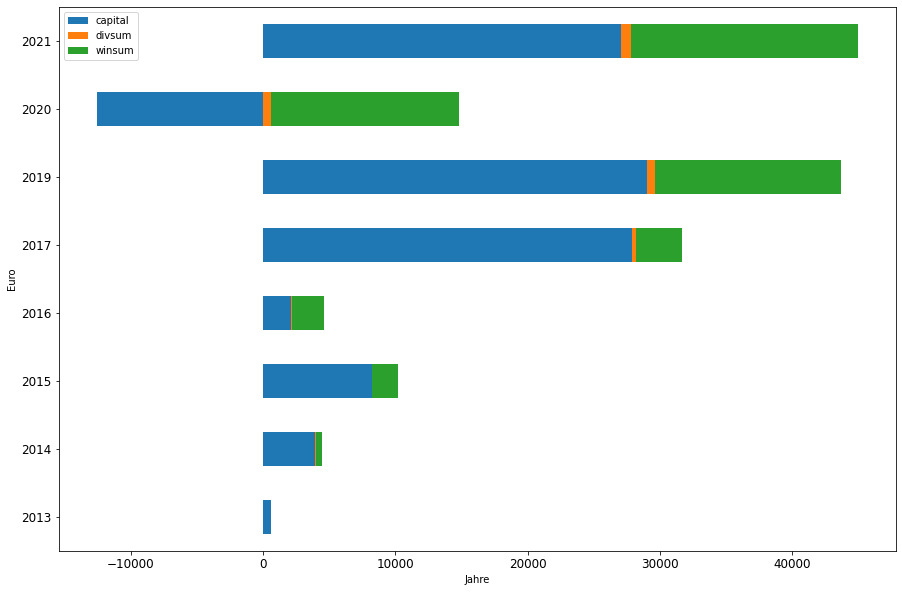

In [46]:
plt.figure()
capitaldf['year'] = capitaldf['year'].map(lambda x: int(x))
plotdf = capitaldf[['year','capital', 'divsum', 'winsum']].copy()
plotdf['capital'] = plotdf['capital'] - plotdf['winsum']
ax = plotdf.plot.barh(use_index=True, fontsize=12, x='year', rot=0, figsize=(15,10), lw=2, stacked=True)
ax.set_xlabel("Jahre")
ax.set_ylabel("Euro")
plt.show()d

## Abgeltungssteuer

In [47]:
print("Gewinn mit Dividende: %.2f (%.2f%%)" % (profit, profit_percent))
outstanding_win = capitaldf.iloc[-1].win
print("Noch nicht realisierter Gewinn: %.2f" % outstanding_win)
realized_win = profit-outstanding_win
print("Realisierter Gewinn: %.2f" % (realized_win))
payed_taxes = 0.25 * realized_win
outstanding_taxes = 0.25 * outstanding_win
print("Entrichtete Steuern: %.2f" % payed_taxes)
print("Noch offene Steuern: %.2f" % outstanding_taxes)
gross_profit = profit + payed_taxes
gross_profit_percent = float(gross_profit) * float(100) / float(invested_capital)
print("Kursgewinn (vor Steuern): %.2f (%.2f%%)" % (gross_profit, gross_profit_percent))

Gewinn mit Dividende: 14710.10 (48.68%)
Noch nicht realisierter Gewinn: 2944.89
Realisierter Gewinn: 11765.21
Entrichtete Steuern: 2941.30
Noch offene Steuern: 736.22
Kursgewinn (vor Steuern): 17651.40 (58.41%)
